In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

### データ読み込み

In [2]:
df = pd.read_csv('train.csv', nrows=550000)
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550000 entries, 0 to 549999
Data columns (total 8 columns):
key                  550000 non-null object
fare_amount          550000 non-null float64
pickup_datetime      550000 non-null object
pickup_longitude     550000 non-null float64
pickup_latitude      550000 non-null float64
dropoff_longitude    549994 non-null float64
dropoff_latitude     549994 non-null float64
passenger_count      550000 non-null int64
dtypes: float64(5), int64(1), object(2)
memory usage: 33.6+ MB


In [4]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,550000.000000,550000.000000,550000.000000,549994.000000,549994.000000,550000.000000
mean,11.348953,-72.527701,39.922421,-72.524337,39.917940,1.683707
std,9.883326,12.545991,7.950921,11.692485,7.297479,1.307607
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-2559.748913,0.000000
25%,6.000000,-73.992043,40.734942,-73.991390,40.734060,1.000000
50%,8.500000,-73.981790,40.752681,-73.980141,40.753135,1.000000
75%,12.500000,-73.967108,40.767092,-73.963602,40.768124,2.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000


### 欠損値の処理

In [5]:
df.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    6
dropoff_latitude     6
passenger_count      0
dtype: int64

In [6]:
df = df.dropna()
df.shape

(549994, 8)

### エラーデータのクリーン

In [7]:
df = df[df['fare_amount'] > 0]
df.shape

(549954, 8)

### 外れ値の処理

ヒストグラムを用いて外れ値を確認．

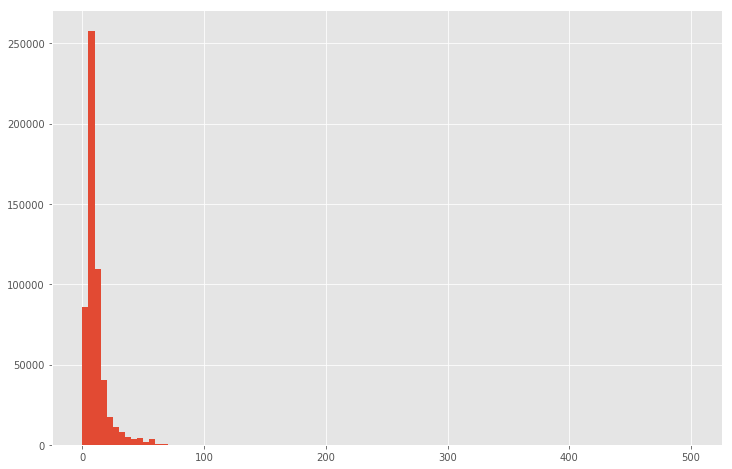

In [8]:
plt.figure(figsize=(12, 8))
plt.hist(df['fare_amount'], bins=100)
plt.show()

実験的に100ドル以下に絞ってみる．

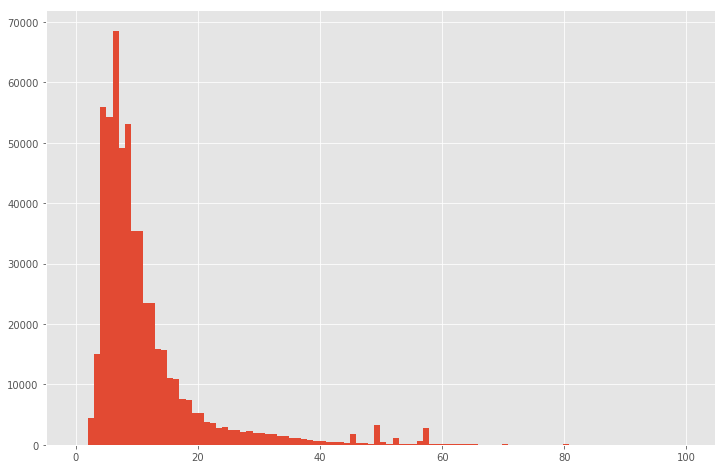

In [9]:
df = df[df['fare_amount'] < 100]
plt.figure(figsize=(12, 8))
plt.hist(df['fare_amount'], bins=100)
plt.show()

四分位数を用いて外れ値を除外．

In [10]:
def outlier_iqr(df, columns=None):
    if columns == None:
        columns = df.columns
    
    for col in columns:
        q1 = df[col].describe()['25%']
        q3 = df[col].describe()['75%']
        iqr = q3 - q1
        
        outlier_min = q1 - iqr * 1.5
        outlier_max = q3 + iqr * 1.5
        
        df = df[(df[col] >= outlier_min) & (df[col] <= outlier_max)]
    
    return df

In [11]:
print('before', df.shape)
df = outlier_iqr(df, columns=['fare_amount'])
print('after', df.shape)

before (549707, 8)
after (502410, 8)


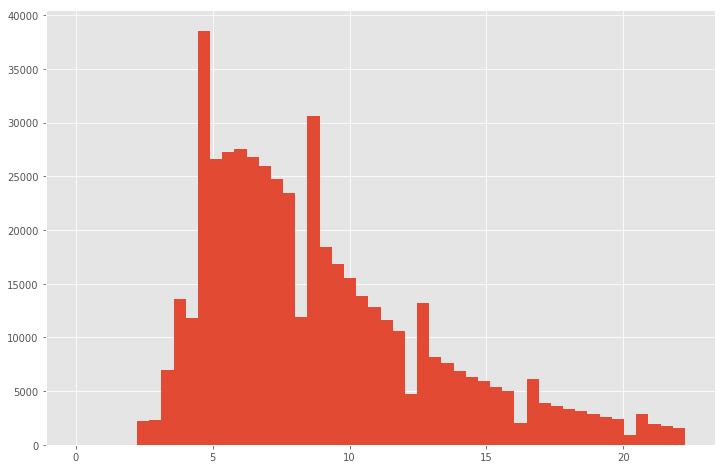

In [12]:
plt.figure(figsize=(12, 8))
plt.hist(df['fare_amount'], bins=50)
plt.show()

緯度・経度の外れ値を除外．

In [13]:
print('before', df.shape)
df = df[(df['pickup_longitude'] > -75) & (df['pickup_longitude'] < -73)]
df = df[(df['pickup_latitude'] > 40) & (df['pickup_latitude'] < 42)]
df = df[(df['dropoff_longitude'] > -75) & (df['dropoff_longitude'] < -73)]
df = df[(df['dropoff_latitude'] > 40) & (df['dropoff_latitude'] < 42)]
print('after', df.shape)

before (502410, 8)
after (492133, 8)


乗客数の外れ値を除外．

In [14]:
df['passenger_count'].value_counts()

1    341337
2     72056
5     34752
3     21456
4     10411
6     10253
0      1868
Name: passenger_count, dtype: int64

In [15]:
print('before', df.shape)
df = df[df['passenger_count'] > 0]
print('after', df.shape)

before (492133, 8)
after (490265, 8)


常識的な統計値になったかどうか確認．

In [16]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,490265.000000,490265.000000,490265.000000,490265.000000,490265.000000,490265.000000
mean,8.933894,-73.979709,40.752227,-73.978072,40.752539,1.686310
std,4.139031,0.028164,0.027131,0.028387,0.028941,1.303497
min,0.010000,-74.968142,40.052722,-74.964263,40.041180,1.000000
25%,5.700000,-73.992532,40.737282,-73.991863,40.737189,1.000000
50%,8.000000,-73.982429,40.753330,-73.981329,40.753990,1.000000
75%,11.000000,-73.970177,40.766867,-73.967958,40.767942,2.000000
max,22.250000,-73.036247,41.800252,-73.029770,41.923820,6.000000


### データを追加

In [17]:
def calculation_distance(x1, y1, x2, y2):
    R = 6371
    _x1, _y1, _x2, _y2 = map(np.radians, [x1, y1, x2, y2])
    
    delta_x = _x2 - _x1
    delta_y = _y2 - _y1
    
    a = np.sin(delta_y / 2.0) ** 2 + np.cos(_y1) * np.cos(_y2) * np.sin(delta_x / 2.0) ** 2
    
    return 2 * R * np.arcsin(np.sqrt(a))

def calculation_azimuth(x1, y1, x2, y2):
    _x1, _y1, _x2, _y2 = map(np.radians, [x1, y1, x2, y2])
    
    delta_x = _x2 - _x1
    _y = np.sin(delta_x)
    _x = np.cos(_y1) * np.tan(_y2) - np.sin(_y1) * np.cos(delta_x)
    
    psi = np.rad2deg(np.arctan2(_y, _x))
    
    return np.where(psi < 0, 360 + psi, psi)

In [18]:
df['distance'] = calculation_distance(df['pickup_longitude'],
                                      df['pickup_latitude'],
                                      df['dropoff_longitude'],
                                      df['dropoff_latitude'])
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,1.030764
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,8.450134
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,1.389525
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2.799270
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.999157


In [19]:
df['azimuth'] = calculation_azimuth(df['pickup_longitude'],
                                    df['pickup_latitude'],
                                    df['dropoff_longitude'],
                                    df['dropoff_latitude'])
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,azimuth
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,167.240469
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,21.498365
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,211.033211
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,352.327836
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,28.802783


In [20]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC')
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
df['month'] = df['pickup_datetime'].dt.month
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['year'] = df['pickup_datetime'].dt.year

df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,azimuth,hour,day,month,dayofweek,year
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,167.240469,17,15,6,0,2009
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,21.498365,16,5,1,1,2010
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,211.033211,0,18,8,3,2011
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,352.327836,4,21,4,5,2012
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,28.802783,7,9,3,1,2010


### 学習データを用意

In [21]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [22]:
X = df.drop(columns=['key', 'fare_amount', 'pickup_datetime'])
y = df['fare_amount']

print(X.shape)
print(y.shape)

(490265, 12)
(490265,)


### データ分割

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=0)

print(X_train.shape)
print(X_test.shape)

(392212, 12)
(98053, 12)


### モデル生成・学習

In [25]:
params = {
    'silent': 1,
    'max_depth': 6,
    'min_child_weight': 1,
    'eta': 0.1,
    'tree_method': 'exact',
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'predictor': 'cpu_predictor'
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
model = xgb.train(params=params,
                  dtrain=dtrain,
                  num_boost_round=1000,
                  early_stopping_rounds=5,
                  evals=[(dtest, 'test')])

[0]	test-rmse:8.518
Will train until test-rmse hasn't improved in 5 rounds.
[1]	test-rmse:7.72211
[2]	test-rmse:7.01123
[3]	test-rmse:6.37683
[4]	test-rmse:5.81231
[5]	test-rmse:5.31045
[6]	test-rmse:4.86549
[7]	test-rmse:4.4716
[8]	test-rmse:4.12459
[9]	test-rmse:3.81989
[10]	test-rmse:3.55372
[11]	test-rmse:3.321
[12]	test-rmse:3.11907
[13]	test-rmse:2.94449
[14]	test-rmse:2.7936
[15]	test-rmse:2.66308
[16]	test-rmse:2.5513
[17]	test-rmse:2.45545
[18]	test-rmse:2.37458
[19]	test-rmse:2.30664
[20]	test-rmse:2.24882
[21]	test-rmse:2.19985
[22]	test-rmse:2.15794
[23]	test-rmse:2.12127
[24]	test-rmse:2.0902
[25]	test-rmse:2.06474
[26]	test-rmse:2.04329
[27]	test-rmse:2.02426
[28]	test-rmse:2.0089
[29]	test-rmse:1.99512
[30]	test-rmse:1.98259
[31]	test-rmse:1.97273
[32]	test-rmse:1.96238
[33]	test-rmse:1.95481
[34]	test-rmse:1.94825
[35]	test-rmse:1.94075
[36]	test-rmse:1.9355
[37]	test-rmse:1.92884
[38]	test-rmse:1.92311
[39]	test-rmse:1.91924
[40]	test-rmse:1.91578
[41]	test-rmse:1.9119

[346]	test-rmse:1.77237
[347]	test-rmse:1.77227
[348]	test-rmse:1.77236
[349]	test-rmse:1.77201
[350]	test-rmse:1.77201
[351]	test-rmse:1.77201
[352]	test-rmse:1.77199
[353]	test-rmse:1.77207
[354]	test-rmse:1.77216
[355]	test-rmse:1.77214
[356]	test-rmse:1.7722
[357]	test-rmse:1.77221
Stopping. Best iteration:
[352]	test-rmse:1.77199



In [26]:
gridsearch_params = [
    (max_depth, eta)
    for max_depth in [6, 7, 8]
    for eta in [0.1, 0.05, 0.01]
]
gridsearch_params

[(6, 0.1),
 (6, 0.05),
 (6, 0.01),
 (7, 0.1),
 (7, 0.05),
 (7, 0.01),
 (8, 0.1),
 (8, 0.05),
 (8, 0.01)]

In [27]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=1000,
    seed=0,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=5
)

cv_results

KeyboardInterrupt: 

In [ ]:
min_rmse = float('Inf')
best_params = []

for max_depth, eta in gridsearch_params:
    print('max_depth={}, eta={}'.format(max_depth, eta))
    
    params['max_depth'] = max_depth
    params['eta'] = eta
    
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=1000,
        seed=0,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=5
    )
    
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    
    print('RMSE {} for {} rounds'.format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth, eta)

print('Best params {}, RMSE {}'.format(best_param, min_rmse))

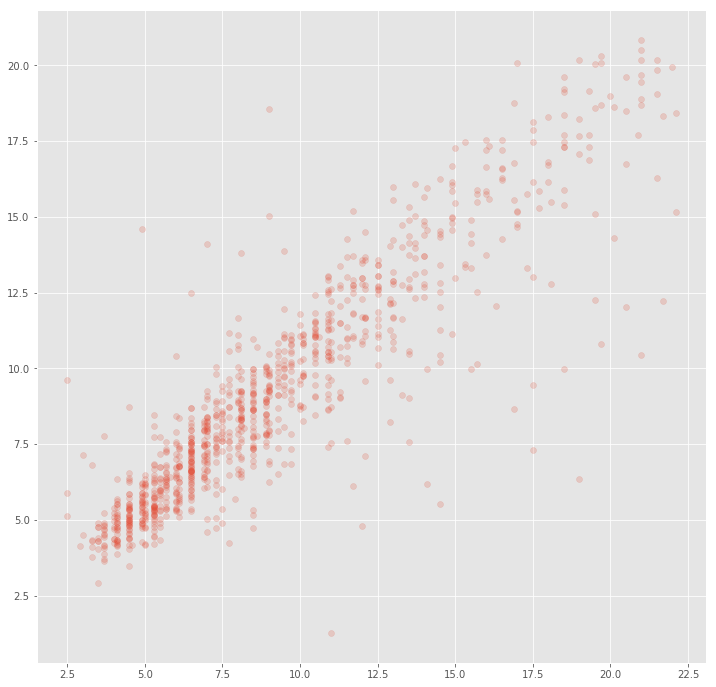

In [28]:
prediction = model.predict(xgb.DMatrix(X_test),
                           ntree_limit=model.best_ntree_limit)

plt.figure(figsize=(12, 12))
plt.scatter(y_test[:1000], prediction[:1000], alpha=0.2)
plt.show()

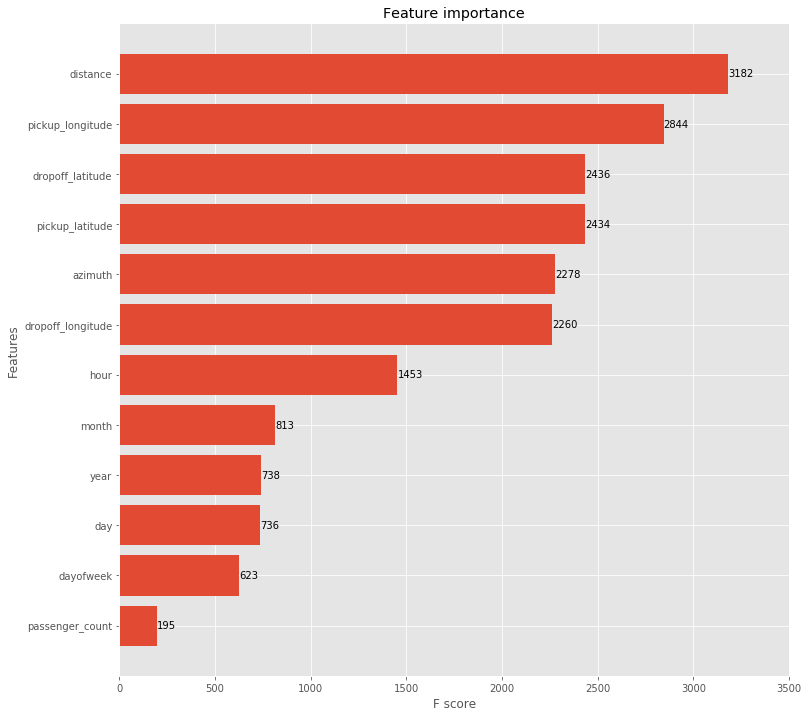

In [29]:
fig, ax = plt.subplots(figsize=(12, 12))
xgb.plot_importance(model, max_num_features=12, height=0.8, ax=ax)
plt.show()